# Images Preprocessing

In the following file, we will go over the image preprocessing steps and the steps we'll be taking before structuring the preprocessing method.


In [8]:
from datasets import load_dataset

train_dataset = load_dataset("Az-r-ow/chest_xray", split="train")

In [9]:
from utils.helpers import format_dataset

labels = train_dataset.features["label"].names

# Converting to pandas will encode the images to bytestrings
train_data = format_dataset(train_dataset, labels)
train_data.head()

,image,label,true_label
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL


In a first step, we will be transforming the images to greyscale, resizing them to (500, 500) then normalize their values and then accumulate them on a canvas to form a pixel heatmap.


In [10]:
import numpy as np

img_size = (500, 500)


def get_heatmap(img, heatmap):
    # Converting the image to a numpy array
    resized_img = np.array(img)
    # Normalizing the image (to have values between 0 and 1)
    resized_img = resized_img / 255
    heatmap = np.add(heatmap, resized_img)

In [11]:
from utils.helpers import resize_grayscale

formatted_images = (
    train_data["image"].map(lambda x: resize_grayscale(x)).reset_index(drop=True)
)

<Axes: >

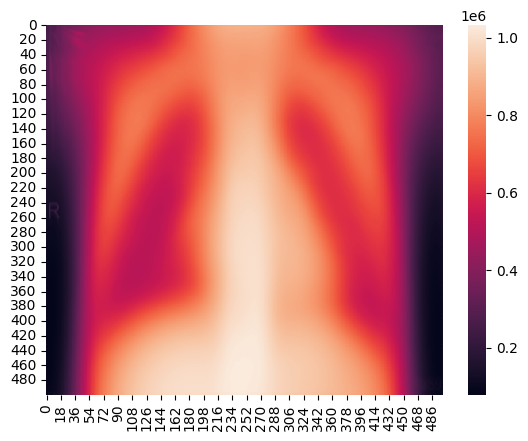

In [12]:
import numpy as np
import seaborn as sns

heatmap = np.zeros(img_size, dtype=np.float64)

for img in formatted_images:
    img = np.array(img)
    heatmap = np.add(heatmap, img)

sns.heatmap(heatmap)

We can notice that we have a very weak pixel density on the sides as well as on the shoulders region. Therefore, we can apply a mask on each image that will nullify these regions.


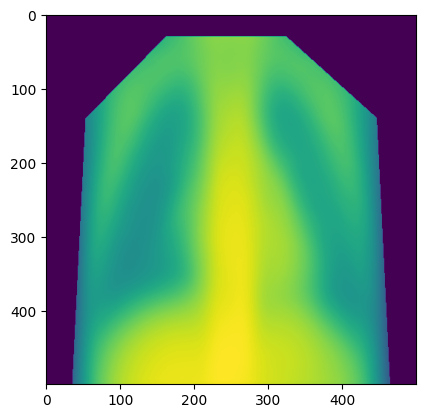

In [14]:
import cv2
from matplotlib import pyplot as plt

sideoffset = 36
topoffset = 30

mask = np.zeros(heatmap.shape[:2])
pts = np.array(
    [
        [162, topoffset],
        [54, 140],
        [sideoffset, 500],
        [500 - sideoffset, 500],
        [500 - 54, 140],
        [324, topoffset],
    ],
    np.int32,
)
pts = pts.reshape((-1, 1, 2))
cv2.fillPoly(mask, [pts], color=1)

# print(mask[100])
masked = mask * heatmap
# sns.heatmap(masked)
plt.imshow(masked)

plt.show()

In [15]:
# Saving the mask in a npz file
np.save("../datasets/mask", mask)